## Malignant Comment Classifier

## INTRODUCTION
__Business Problem Framing__
The proliferation of social media enables people to express their opinions widely online. However, at the same time, this has resulted in the emergence of conflict and hate, making online environments uninviting for users. Although researchers have found that hate is a problem across multiple platforms, there is a lack of models for online hate detection.
Online hate, described as abusive language, aggression, cyber bullying, hatefulness and many others has been identified as a major threat on online social media platforms. Social media platforms are the most prominent grounds for such toxic behaviour.   
There has been a remarkable increase in the cases of cyber bullying and trolls on various social media platforms. Many celebrities and influences are facing backlashes from people and have to come across hateful and offensive comments. This can take a toll on anyone and affect them mentally leading to depression, mental illness, self-hatred and suicidal thoughts.    


Internet comments are bastions of hatred and vitriol. While online anonymity has provided a new outlet for aggression and hate speech, machine learning can be used to fight it. The problem we sought to solve was the tagging of internet comments that are aggressive towards other users. This means that insults to third parties such as celebrities will be tagged as unoffensive, but “u are an idiot” is clearly offensive.
Our goal is to build a prototype of online hate and abuse comment classifier which can used to classify hate and offensive comments so that it can be controlled and restricted from spreading hatred and cyber bullying. 

The data set contains the training set, which has approximately 1,59,000 samples and the test set which contains nearly 1,53,000 samples. All the data samples contain 8 fields which includes ‘Id’, ‘Comments’, ‘Malignant’, ‘Highly malignant’, ‘Rude’, ‘Threat’, ‘Abuse’ and ‘Loathe’. 
The label can be either 0 or 1, where 0 denotes a NO while 1 denotes a YES. There are various comments which have multiple labels. The first attribute is a unique ID associated with each comment.   
The data set includes:
-	Malignant: It is the Label column, which includes values 0 and 1, denoting if the comment is malignant or not. 
-	Highly Malignant: It denotes comments that are highly malignant and hurtful. 
-	Rude: It denotes comments that are very rude and offensive.
-	Threat: It contains indication of the comments that are giving any threat to someone. 	
-	Abuse: It is for comments that are abusive in nature. 
-	Loathe: It describes the comments which are hateful and loathing in nature.  
-	ID: It includes unique Ids associated with each comment text given.   
-	Comment text: This column contains the comments extracted from various social media platforms. 




## Importing required Libraries

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.metrics import f1_score,precision_score, multilabel_confusion_matrix, accuracy_score,jaccard_score, recall_score, hamming_loss
from sklearn.multiclass import OneVsRestClassifier

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Loading the data

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
#lets check the shape of the data 
df.shape

(159571, 8)

By looking at the shape of our training data set we came to know that this data set is having 159571 rows and 8 columns. where malignant, highly_malignant,rude,threat, abuse and loathe are our target variabls which are with binary values.

In [4]:
#lets check the data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


The column comment_text contains different comments based on which these comments have been labeled. 

## Lets see how the comments look like

In [5]:
df['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [6]:
df['comment_text'][1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

By observing these comments we can say that we need to do lot of text processing as there are many words wich are not important for prediction, as well as numbers and other stuff.

In [7]:
# Check percentage of comments that are toxic compared to normal comments
df.malignant.value_counts(normalize=True)

0    0.904156
1    0.095844
Name: malignant, dtype: float64

We can see about 90% of the comments falls down into malignant category

In [8]:
#Create a new subset of the data by only taking the 2nd column onwards (comments and categories)
data_count = df.iloc[:,2:].sum()

In [9]:
data_count

malignant           15294
highly_malignant     1595
rude                 8449
threat                478
abuse                7877
loathe               1405
dtype: int64

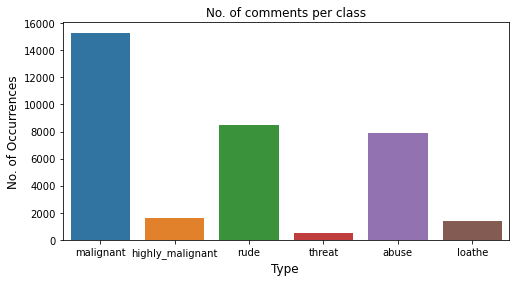

In [10]:
# Plot a chart with the following size
plt.figure(figsize=(8,4))

# Plot a bar chart using the index (category values) and the count of each category.
ax = sns.barplot(data_count.index, data_count.values)

plt.title("No. of comments per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
plt.show()


Looking at this plot we can say that among all labels the percentage of malignant comments is more.

## Feature Engineering

I am creating three different columns length, exclamation and question based on conditions 

In [11]:
def feature_engg(df):
    
    df['length'] = df.comment_text.apply(lambda x: len(x))

    df['exclamation'] = df.comment_text.apply(lambda s: len([c for c in s if c == '!']))

    df['question'] = df.comment_text.apply(lambda s: len([c for c in s if c == '?']))

    # Normalization
    for label in ['length','question', 'exclamation']:
        minimum = df[label].min()
        diff = df[label].max() - minimum
        df[label] = df[label].apply(lambda x: (x-minimum) / (diff))


In [12]:
feature_engg(df)

In [13]:
df

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,length,exclamation,question
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0.051852,0.000000,0.004785
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0.021421,0.000202,0.000000
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0.045646,0.000000,0.000000
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0.123524,0.000000,0.000000
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0.012412,0.000000,0.004785
...,...,...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,0.058058,0.000000,0.009569
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,0.018819,0.000000,0.000000
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,0.015215,0.000000,0.000000
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,0.022222,0.000000,0.000000


### Text processing

In [14]:
#importing required libraries for text processing 
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import wordnet
from nltk.corpus import wordnet as wn

In [15]:
#function for lemmatization
def lemm(text):
    lemmatizer = wordnet.WordNetLemmatizer()
    word_tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(word, wn.VERB) for word in word_tokens]
    
    return " ".join(lemmas)
#function for removing stopwords    
def rem_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in string.punctuation]
    filtered_text = [word for word in filtered_text if word not in stop_words]
    return " ".join(filtered_text)

def decontracted(text):
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"im", "i am", text)
    text = re.sub(r"yo", "you",text)
    text = re.sub(r"youu", "you",text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r'http\S+', '', text) #removing urls
    return text

Now finally I will make a function to process our comment_text column using above functions.

In [16]:
def text_proc(df):
    
    df['comment_text'] = df.comment_text.apply(lambda x: x.lower()) #lowering all text
    df['comment_text'] = df.comment_text.apply(lambda x: re.sub(r'\d+','',x)) #removing numbers
    df['comment_text'] = df.comment_text.apply(lambda x: re.sub(r'\n',' ',x)) #removing \n
    df['comment_text'] = df.comment_text.apply(lambda x: decontracted(x))
    df['comment_text'] = df.comment_text.apply(lambda x: lemm(x))
    
    #removing punctuations
    translator = str.maketrans('','', string.punctuation)
    df['comment_text'] = df.comment_text.apply(lambda x : x.translate(translator))
    df['comment_text'] = df.comment_text.apply(lambda x: rem_stopwords(x))
text_proc(df)

In [17]:
#lets have a look at data set now
df

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,length,exclamation,question
0,0000997932d777bf,explanation edit make username hardcore metall...,0,0,0,0,0,0,0.051852,0.000000,0.004785
1,000103f0d9cfb60f,daww match background colour seemingly stick t...,0,0,0,0,0,0,0.021421,0.000202,0.000000
2,000113f07ec002fd,hey man really try edit war guy constantly rem...,0,0,0,0,0,0,0.045646,0.000000,0.000000
3,0001b41b1c6bb37e,make real suggestions amprovement wonder secti...,0,0,0,0,0,0,0.123524,0.000000,0.000000
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0,0.012412,0.000000,0.004785
...,...,...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,second ti ame ask view completely contradict c...,0,0,0,0,0,0,0.058058,0.000000,0.009569
159567,ffea4adeee384e90,ashamed horrible thing put talk page,0,0,0,0,0,0,0.018819,0.000000,0.000000
159568,ffee36eab5c267c9,spitzer umm theres actual article prostitution...,0,0,0,0,0,0,0.015215,0.000000,0.000000
159569,fff125370e4aaaf3,look like actually put speedy first version de...,0,0,0,0,0,0,0.022222,0.000000,0.000000


In [18]:
#check the value counts of id column
df.id.value_counts()

449d0a4ab5964652    1
02cddf405a42105b    1
588e88fa7ec89467    1
f4a5088c629389a4    1
31d069b517569672    1
                   ..
230865f6867a1245    1
bc9ba36154464356    1
9f20c9ae8905192f    1
50266c907b94d97d    1
135bd031ef8bc766    1
Name: id, Length: 159571, dtype: int64

As the column id is having unique entries for every row we don't need this column for prediction

## EDA

In [19]:
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [20]:
def wordcloud(df, label):
    
    # Print only rows where the toxic category label value is 1 (ie. the comment is toxic)
    subset=df[df[label]==1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="white",max_words=4000)

    wc.generate(" ".join(text))

    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244))

In [21]:
df_mal = df.loc[:,['id','comment_text','malignant']]

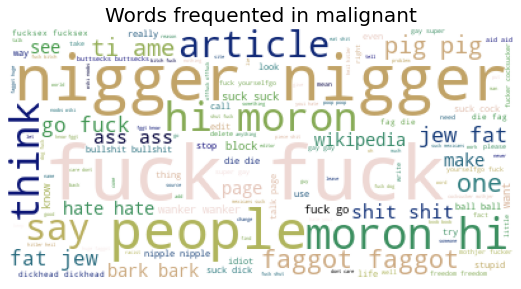

In [22]:
wordcloud(df_mal, 'malignant')

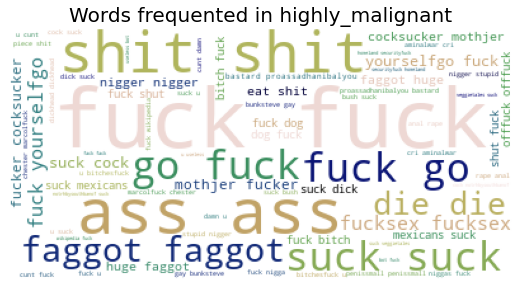

In [23]:
df_Hmal = df.loc[:,['id','comment_text','highly_malignant']]
wordcloud(df_Hmal, 'highly_malignant')

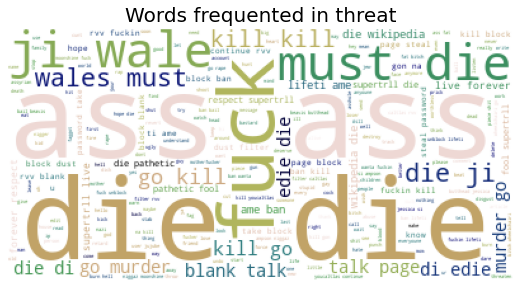

In [24]:
df_thr = df.loc[:,['id','comment_text','threat']]
wordcloud(df_thr, 'threat')

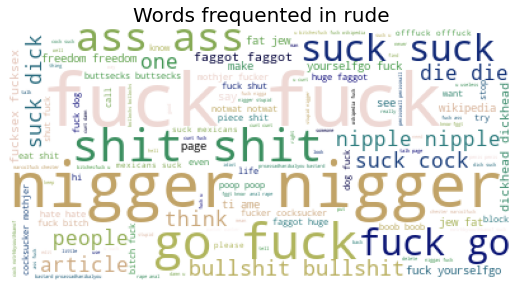

In [25]:
df_rud = df.loc[:,['id','comment_text','rude']]
wordcloud(df_rud, 'rude')

## Model building

### Here for this project I am using Tfidf vectorizer for our text column to convert text into vectors.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier

tfidf = TfidfVectorizer(analyzer='word',max_features=4000)

In [27]:
y = df.drop(columns = ['id','comment_text','length','exclamation','question'])

In [28]:
x = tfidf.fit_transform(df.comment_text)

In [29]:
x

<159571x4000 sparse matrix of type '<class 'numpy.float64'>'
	with 3470169 stored elements in Compressed Sparse Row format>

In [30]:
#tfidf.vocabulary_

In [31]:
#lets check the shape of x and y
x.shape, y.shape

((159571, 4000), (159571, 6))

##### Lets add remaining features to the X

In [32]:
length = []
exclamation = []
question = []

for i in df.length:
   length.append([i])
for i in df.exclamation:
   exclamation.append([i])
for i in df.question:
   question.append([i])

In [33]:
import scipy as sp
X = sp.sparse.hstack((x, length, exclamation, question))

In [34]:
X.shape, y.shape

((159571, 4003), (159571, 6))

## Spliting data into train and test sets

In [35]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 42)

In [36]:
#lets define different algorithms
svc = LinearSVC()
lr = LogisticRegression(solver='lbfgs')
mnb = MultinomialNB()
lgb = LGBMClassifier()
sgd = SGDClassifier()

In [37]:
#function for printing score
def print_score(y_pred,clf):
    print('classifier:',clf.__class__.__name__)
    print("Jaccard score: {}".format(jaccard_score(y_test,y_pred,average='micro')))
    print("Accuracy score: {}".format(accuracy_score(y_test,y_pred)))
    print("f1_score: {}".format(f1_score(y_test,y_pred,average='micro')))
    print("Precision : ", precision_score(y_test,y_pred,average='micro'))
    print("Recall: {}".format(recall_score(y_test,y_pred,average='micro')))
    print("Hamming loss: ", hamming_loss(y_test,y_pred))
    print("Confusion matrix:\n ", multilabel_confusion_matrix(y_test,y_pred))
    print('========================================\n')    

In [38]:
#models with evaluation using OneVsRestClassifier
for classifier in [svc,lr,mnb,sgd,lgb]:
   clf = OneVsRestClassifier(classifier)
   clf.fit(x_train,y_train)
   y_pred = clf.predict(x_test)
   print_score(y_pred, classifier)

classifier: LinearSVC
Jaccard score: 0.5454731248722665
Accuracy score: 0.9194595543077733
f1_score: 0.7058979106056599
Precision :  0.8490536026721807
Recall: 0.6040511485798348
Hamming loss:  0.018583042973286876
Confusion matrix:
  [[[35693   385]
  [ 1267  2548]]

 [[39421    66]
  [  305   101]]

 [[37589   161]
  [  695  1448]]

 [[39769    19]
  [   82    23]]

 [[37611   271]
  [  872  1139]]

 [[39489    47]
  [  278    79]]]

classifier: LogisticRegression
Jaccard score: 0.5223303001778057
Accuracy score: 0.9198355601233299
f1_score: 0.6862246650635521
Precision :  0.8733823015040224
Recall: 0.565123910829467
Hamming loss:  0.01908020621830062
Confusion matrix:
  [[[35821   257]
  [ 1430  2385]]

 [[39416    71]
  [  290   116]]

 [[37620   130]
  [  774  1369]]

 [[39781     7]
  [   92    13]]

 [[37650   232]
  [  960  1051]]

 [[39509    27]
  [  297    60]]]

classifier: MultinomialNB
Jaccard score: 0.43888415672913117
Accuracy score: 0.9130925224976812
f1_score: 0.61003

## Hyperparameter Tuning

In [39]:
param = {
        'estimator__penalty': ['l1'],
        'estimator__loss': ['hinge','squared_hinge'],
        'estimator__multi_class': ['ovr','crammer_singer'],
        'estimator__dual': [False],
        'estimator__intercept_scaling': [2,4,5],
        'estimator__C': [2]
        }

In [40]:
#train the model with given parameters using GridSearchCV
svc = OneVsRestClassifier(LinearSVC())
GCV =  GridSearchCV(svc,param,cv = 3, verbose =0,n_jobs=-1)
GCV.fit(x_train,y_train)

GridSearchCV(cv=3, estimator=OneVsRestClassifier(estimator=LinearSVC()),
             n_jobs=-1,
             param_grid={'estimator__C': [2], 'estimator__dual': [False],
                         'estimator__intercept_scaling': [2, 4, 5],
                         'estimator__loss': ['hinge', 'squared_hinge'],
                         'estimator__multi_class': ['ovr', 'crammer_singer'],
                         'estimator__penalty': ['l1']})

In [41]:
GCV.best_params_       #printing the best parameters found by GridSearchCV

{'estimator__C': 2,
 'estimator__dual': False,
 'estimator__intercept_scaling': 4,
 'estimator__loss': 'squared_hinge',
 'estimator__multi_class': 'ovr',
 'estimator__penalty': 'l1'}

## Final model

In [42]:
model = OneVsRestClassifier(LinearSVC(C=2,dual = False, loss='squared_hinge',multi_class='ovr', penalty ='l1',intercept_scaling=4))
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

print("Jaccard score: {}".format(jaccard_score(y_test,y_pred,average='micro')))
print("Accuracy score: {}".format(accuracy_score(y_test,y_pred)))
print("f1_score: {}".format(f1_score(y_test,y_pred,average='micro')))
print("Precision : ", precision_score(y_test,y_pred,average='micro'))
print("Recall: {}".format(recall_score(y_test,y_pred,average='micro')))
print("Hamming loss: ", hamming_loss(y_test,y_pred))
print("\nConfusion matrix: \n", multilabel_confusion_matrix(y_test,y_pred))


Jaccard score: 0.5499033472377658
Accuracy score: 0.9195848895796255
f1_score: 0.7095969541814362
Precision :  0.8449273096764108
Recall: 0.611632907095168
Hamming loss:  0.018482774755805113

Confusion matrix: 
 [[[35680   398]
  [ 1239  2576]]

 [[39413    74]
  [  295   111]]

 [[37581   169]
  [  682  1461]]

 [[39763    25]
  [   76    29]]

 [[37605   277]
  [  873  1138]]

 [[39487    49]
  [  267    90]]]


In [43]:
model.predict(X)

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

## Model Saving

In [45]:
import joblib
joblib.dump(model,"Malignant_comment_clfr.pkl")

['Malignant_comment_clfr.pkl']

In [46]:
#loading the model
model = joblib.load('Malignant_comment_clfr.pkl')

## Prediction for test dataset using final model

In [47]:
#Lets load the test data set
test = pd.read_csv('test.csv')
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [48]:
feature_engg(test)  #feature engineering
test.head()

,id,comment_text,length,exclamation,question
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0.073215,0.0,0.0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0.009802,0.0,0.0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0.010602,0.0,0.0
3,00017563c3f7919a,":If you have a look back at the source, the in...",0.040808,0.0,0.0
4,00017695ad8997eb,I don't anonymously edit articles at all.,0.008002,0.0,0.0


In [49]:
text_proc(test)   #processing the test data set

test.head()

,id,comment_text,length,exclamation,question
0,00001cee341fdb12,bitch ja rule succesful ever whats hat sad mof...,0.073215,0.0,0.0
1,0000247867823ef7,rfc title fine amo,0.009802,0.0,0.0
2,00013b17ad220c46,source zawe ashton lapland —,0.010602,0.0,0.0
3,00017563c3f7919a,look back source information update correct fo...,0.040808,0.0,0.0
4,00017695ad8997eb,anonymously edit article,0.008002,0.0,0.0


In [50]:
tfidf = TfidfVectorizer(analyzer = 'word', max_features=4000)
X = tfidf.fit_transform(test.comment_text)

In [51]:
length = []
exclamation = []
question = []
source = []
for i in test.length:
   length.append([i])
for i in test.exclamation:
   exclamation.append([i])
for i in test.question:
   question.append([i])

import scipy as sp
X_test = sp.sparse.hstack((X, length, exclamation, question))

In [52]:
#lets predict the output
model.predict(X_test)

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [53]:
predictions = model.predict(X_test)

In [54]:
pred=pd.DataFrame(predictions, columns = ['malignant','highly_malignant','rude','threat','abuse','loathe'])
pred

,malignant,highly_malignant,rude,threat,abuse,loathe
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
153159,0,0,0,0,0,0
153160,0,0,0,0,0,0
153161,0,0,0,0,0,0
153162,0,0,0,0,0,0


In [62]:
x_test = pd.concat([test,pred], axis=1)
x_test

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0,0,0,0,0,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0,0,0,0,0,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0,0,0,0,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",0,0,0,0,0,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",0,0,0,0,0,0
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,0,0,0,0,0,0
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",0,0,0,0,0,0
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",0,0,0,0,0,0


In [63]:
#saving the data into csv file
x_test.to_csv(r"C:\Users\ABHINANDAN\Desktop\test_predictions.csv")